In [115]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [116]:
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [117]:
train_df["non_toxic"] = train_df.iloc[:,2:8].apply(lambda x: 1 if (sum(x)==0) else 0, axis=1)
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [118]:
total={}
for col in train_df.iloc[:,2:].columns:
    total[col]=train_df[col].value_counts()[1]
    print(f"{col}: {total[col]}\n")

toxic: 15294

severe_toxic: 1595

obscene: 8449

threat: 478

insult: 7877

identity_hate: 1405

non_toxic: 143346



In [119]:
train_df['classes']=train_df.iloc[:,2:8].sum(axis=1)
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,classes
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1,0


In [120]:
label_totals={}
for label in train_df['classes'].unique():
    label_totals[label]=train_df['classes'].value_counts()[label]

label_totals

{0: 143346, 4: 1760, 1: 6360, 3: 4209, 2: 3480, 5: 385, 6: 31}

In [121]:
keys=[key for key in label_totals.keys()]
values=[key for key in label_totals.values()]
keys1=keys.copy()
values1=values.copy()
keys1.pop(0)
values1.pop(0)

143346

Text(0.5, 1.0, 'Plot excluding unlabeled(0) comments')

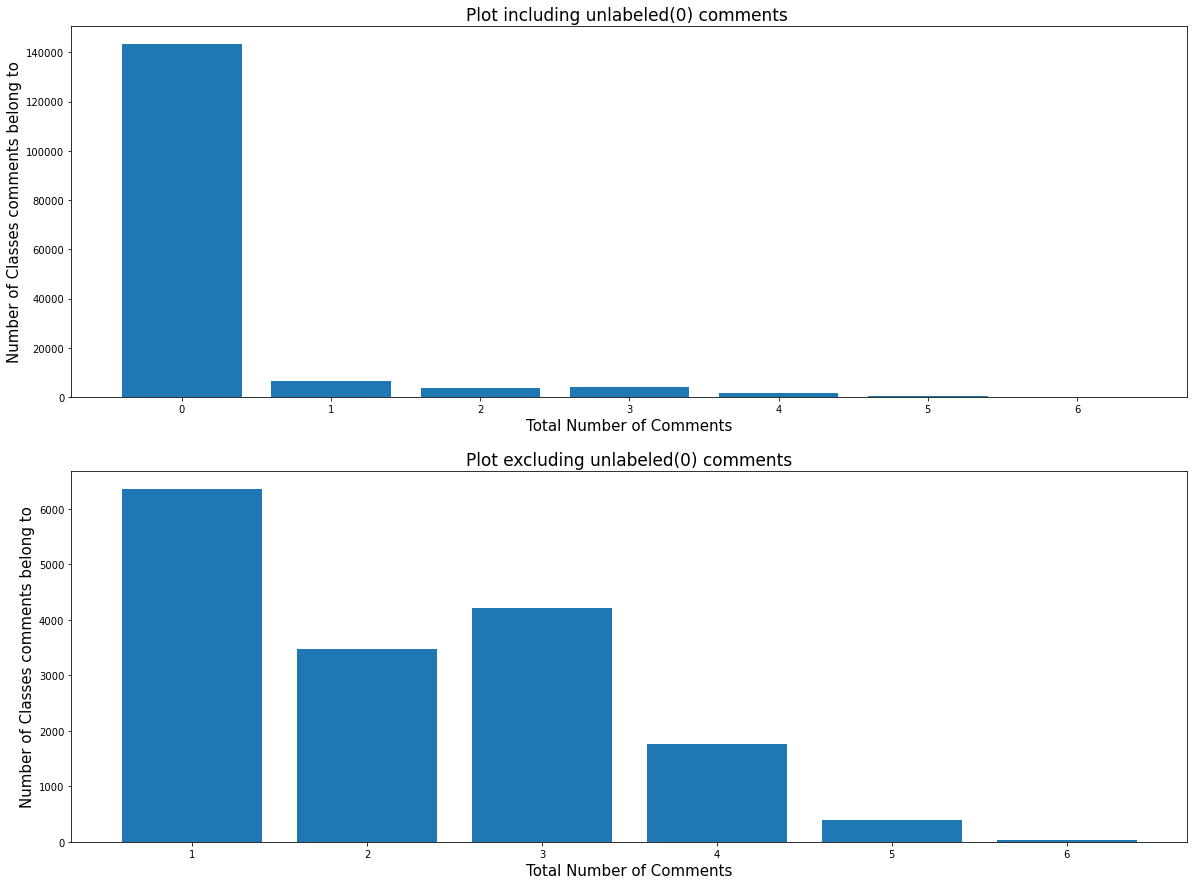

In [122]:
plt.figure(figsize=(20,15))

fr = plt.subplot(2,1,1)
plt.bar(keys,values)

fr.set_xlabel("Total Number of Comments", fontsize=15)
fr.set_ylabel("Number of Classes comments belong to", fontsize=15)
fr.set_title("Plot including unlabeled(0) comments ", fontsize=17)


se = plt.subplot(2,1,2)
plt.bar(keys1, values1)

se.set_xlabel("Total Number of Comments", fontsize=15)
se.set_ylabel("Number of Classes comments belong to", fontsize=15)
se.set_title("Plot excluding unlabeled(0) comments", fontsize=17)

Text(0.5, 1.0, 'distribution of classes without non toxic values')

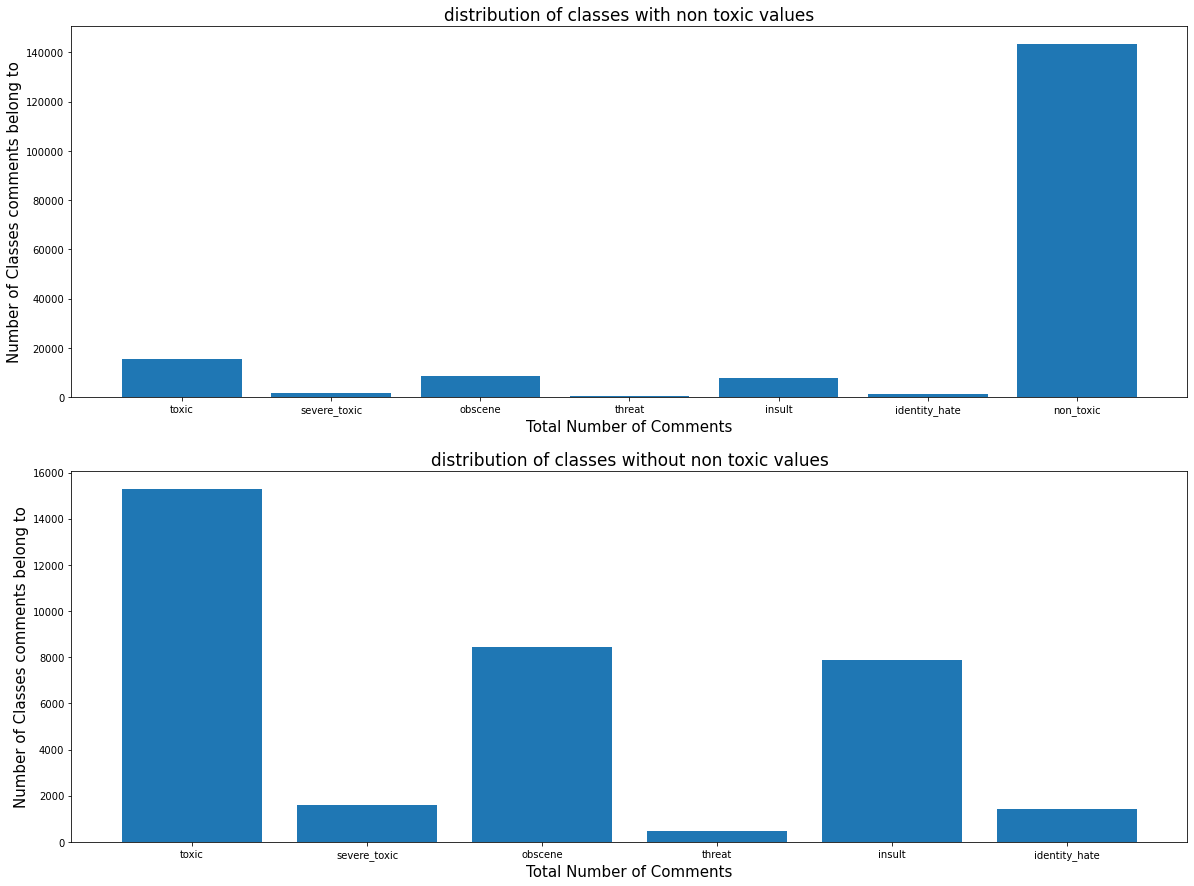

In [123]:
plt.figure(figsize=(20,15))
rude=list(total.values())

fr = plt.subplot(2,1,1)
plt.bar(x = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate','non_toxic'],height=total.values())

fr.set_xlabel("Total Number of Comments", fontsize=15)
fr.set_ylabel("Number of Classes comments belong to", fontsize=15)
fr.set_title("distribution of classes with non toxic values", fontsize=17)


se = plt.subplot(2,1,2)
plt.bar(x = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'], height=rude[:-1])

se.set_xlabel("Total Number of Comments", fontsize=15)
se.set_ylabel("Number of Classes comments belong to", fontsize=15)
se.set_title("distribution of classes without non toxic values", fontsize=17)

In [124]:
processed_data=train_df.copy()

In [125]:
processed_data['comment_text'].tolist()

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

In [126]:
#Removing IP address
processed_data['comment_text']=processed_data['comment_text'].map(lambda x: re.sub(r"([0-9]{1,3})\.([0-9]{1,3})\.([0-9]{1,3})\.([0-9]{1,3})","",x))


In [127]:
#Getting ride of the URLs with space even if they are in paranthesis 
processed_data['comment_text']=processed_data['comment_text'].map(lambda x:re.sub(r"\S*https?:\S*|\s*www\.\s*", "", x))


In [128]:
#Remove special characters even if they are in paranthesis 
processed_data['comment_text']=processed_data['comment_text'].map(lambda x: re.sub(r'\s*[^a-zA-Z0-9]\s*',' ',x))

In [132]:
#Removing extra spaces in the text 
processed_data['comment_text']=processed_data['comment_text'].map(lambda x: re.sub(r"\s\s+", " ",x))

In [136]:
processed_data.drop(columns=["id"],inplace=True)

In [140]:
working_data=processed_data.copy()
C_indexs = processed_data[processed_data["classes"]==0].index
C_indexs.shape

(143346,)

In [141]:
#Keep 5000 of non_toxic comments and drop the rest
drop_ind=np.random.choice(C_indexs, size=138346, replace=False)
working_data.drop(drop_ind, inplace=True)


In [143]:
def Graph(A,B):
    classes={}
    for col in A.iloc[:.1:].columns:
        classes[col]=A[col].value_counts()[1]
    classes_B={}
    for col in B.iloc[:,1:].columns:
        classes_B[col]=B[col].value_counts()[1]
    multi_class_A={}
    for value in A['classes'].unique():
        multi_class_A[value]=A['classes'].value_counts()[value]
    multi_class_B={}
    for values in B['Classes'].unique():
        multi_class_B[value]=B['classes'].value_counts()[value]

    key_A=[for key in  ]
    

SyntaxError: invalid syntax (272817031.py, line 2)

In [ ]:
#TF-IDF
tf_idf=TfidfVectorizer(max_features=150, ngram=[1,3])
temp=tf_idf.fit_transform(train_df['comment_text'])
tok_cols=tf_idf.get_feature_names()
tok_df=pd.DataFrame(temp.toarray(), columns=tok_cols)
tok_df.head()


NameError: name 'TfidfVectorizer' is not defined

## Test Data

In [ ]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [ ]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
dummy_toxic = [0,0,0,0]
dummy_severe = [0,0,0,0]
dummy_obscene = [0,1,1,0]
dummy_threat = [0,1,0,1]
dummy_insult = [0,0,1,0]
dummy_ident = [0,1,1,0]
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
                    columns=columns)
sample_out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,dfasdf234,0,0,0,0,0,0
1,asdfgw43r52,0,0,1,1,0,1
2,asdgtawe4,0,0,1,0,1,1
3,wqtr215432,0,0,0,1,0,0


In [ ]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>